In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal
import neurokit2 as nk
import mne
from bibliotheque import *
%matplotlib inline
# %matplotlib widget

In [101]:
def preprocessing(sig, dtype):
    if dtype == 'ECG':
        clean = nk.ecg_clean(sig)
    elif dtype == 'EDA':
        clean = nk.eda_clean(sig)
    elif dtype == 'PPG':
        clean = nk.ppg_clean(sig)
    elif dtype == 'EEGL' or dtype == 'EEGR':
        clean = mne.filter.filter_data(sig, 1000, l_freq = 0.1, h_freq = None) # remove slow drift with high pass 0.1
        clean = mne.filter.notch_filter(sig, 1000, freqs=np.arange(50,201,50)) # notch filter to remove line_noise
    return clean

In [83]:
participants = ['PERSA01_1','GHIVA02_2','MONLI03_3']
dtypes = ['EEGL','EEGR','ECG','EDA','PPG']

In [27]:
das = []
for participant in participants:
    da = xr.load_dataarray(f'../data_in_da/da_{participant}.nc')
    das.append(da)
da_all = xr.concat(das, dim = 'participant')
da_all = da_all.assign_coords({'participant':participants})

In [28]:
da_all

<xarray.DataArray (participant: 3, dtype: 5, time: 3737000)>
array([[[ 575.,  577.,  579., ...,   nan,   nan,   nan],
        [ 615.,  622.,  625., ...,   nan,   nan,   nan],
        [ 593.,  585.,  579., ...,   nan,   nan,   nan],
        [ 679.,  679.,  679., ...,   nan,   nan,   nan],
        [  28.,   28.,   28., ...,   nan,   nan,   nan]],

       [[ 377.,  409.,  448., ...,   nan,   nan,   nan],
        [ 633.,  630.,  617., ...,   nan,   nan,   nan],
        [ 470.,  471.,  472., ...,   nan,   nan,   nan],
        [ 253.,  252.,  252., ...,   nan,   nan,   nan],
        [  30.,   30.,   30., ...,   nan,   nan,   nan]],

       [[1014., 1014., 1014., ...,    0.,    0.,    0.],
        [ 770.,  802.,  793., ..., 1014., 1014., 1014.],
        [ 313.,  299.,  290., ...,  547.,  553.,  558.],
        [  72.,   72.,   72., ...,  331.,  331.,  331.],
        [  32.,   32.,   32., ...,   27.,   27.,   27.]]])
Coordinates:
  * time         (time) float64 0.0 0.001 0.002 ... 3.737e+03 3.737e+03
  * dtype        (dtype) object 'EEGL' 'EEGR' 'ECG' 'EDA' 'PPG'
  * participant  (participant) <U9 'PERSA01_1' 'GHIVA02_2' 'MONLI03_3'

In [57]:
def time_duration_by_participant():
    rows = []
    for participant in participants:
        duration = float(da_all.sel(participant = participant).dropna(dim='time').coords['time'][-1].values)
        rows.append([participant, duration])
    df = pd.DataFrame(rows, columns = ['participant','duration']).set_index('participant')
    return df.round(2)
time_duration_by_participant()

,duration
participant,
PERSA01_1,661.0
GHIVA02_2,3463.0
MONLI03_3,3737.0


In [105]:
da_cleans = []
for participant in participants:
    da_clean = None
    print(participant)
    for dtype in dtypes:
        print(dtype)
        sig = da_all.loc[participant, dtype, :].dropna(dim='time').values
        # print(sig.size)
        clean = preprocessing(sig, dtype)
        if da_clean is None:
            da_clean = init_da({'dtype':dtypes, 'time':time_vector(sig, 1000)})
        da_clean.loc[dtype, :] = clean
    da_cleans.append(da_clean)
da_cleans = xr.concat(da_cleans, dim = 'participant')
da_cleans = da_cleans.assign_coords({'participant':participants})
da_both = xr.concat([da_all, da_cleans], dim = 'cleaning')
da_both = da_both.assign_coords({'cleaning':['raw','clean']})

PERSA01_1
EEGL
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

EEGR
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
-

In [122]:
da_both

<xarray.DataArray (cleaning: 2, participant: 3, dtype: 5, time: 3737000)>
array([[[[ 5.75000000e+02,  5.77000000e+02,  5.79000000e+02, ...,
                      nan,             nan,             nan],
         [ 6.15000000e+02,  6.22000000e+02,  6.25000000e+02, ...,
                      nan,             nan,             nan],
         [ 5.93000000e+02,  5.85000000e+02,  5.79000000e+02, ...,
                      nan,             nan,             nan],
         [ 6.79000000e+02,  6.79000000e+02,  6.79000000e+02, ...,
                      nan,             nan,             nan],
         [ 2.80000000e+01,  2.80000000e+01,  2.80000000e+01, ...,
                      nan,             nan,             nan]],

        [[ 3.77000000e+02,  4.09000000e+02,  4.48000000e+02, ...,
                      nan,             nan,             nan],
         [ 6.33000000e+02,  6.30000000e+02,  6.17000000e+02, ...,
                      nan,             nan,             nan],
         [ 4.70000000e+02,  4.71000000e+02,  4.72000000e+02, ...,
                      nan,             nan,             nan],
         [ 2.53000000e+02,  2.52000000e+02,  2.52000000e+02, ...,
                      nan,             nan,             nan],
         [ 3.00000000e+01,  3.00000000e+01,  3.00000000e+01, ...,
...
                      nan,             nan,             nan],
         [ 6.33000000e+02,  6.32058952e+02,  6.20149675e+02, ...,
                      nan,             nan,             nan],
         [-9.26502089e+00, -8.29218639e+00, -7.31435105e+00, ...,
                      nan,             nan,             nan],
         [ 2.52714412e+02,  2.52710015e+02,  2.52705593e+02, ...,
                      nan,             nan,             nan],
         [-1.14236586e+01, -1.07873243e+01, -1.01514409e+01, ...,
                      nan,             nan,             nan]],

        [[ 1.01400000e+03,  1.04084131e+03,  1.06664279e+03, ...,
          -1.57468209e+01, -4.19393438e+00,  4.13002965e-14],
         [ 7.70000000e+02,  7.91735726e+02,  7.78767740e+02, ...,
           9.80416391e+02,  9.94156141e+02,  1.01400000e+03],
         [-2.82519868e+01, -2.70999423e+01, -2.58404016e+01, ...,
          -5.00722327e+01, -4.69358538e+01, -4.37924724e+01],
         [ 7.18920757e+01,  7.18893838e+01,  7.18866654e+01, ...,
           3.31770656e+02,  3.31770654e+02,  3.31770653e+02],
         [-8.40559456e+00, -7.77433751e+00, -7.14499662e+00, ...,
           2.87702831e-03,  2.48744536e-04, -3.74784943e-05]]]])
Coordinates:
  * time         (time) float64 0.0 0.001 0.002 ... 3.737e+03 3.737e+03
  * dtype        (dtype) object 'EEGL' 'EEGR' 'ECG' 'EDA' 'PPG'
  * participant  (participant) <U9 'PERSA01_1' 'GHIVA02_2' 'MONLI03_3'
  * cleaning     (cleaning) <U5 'raw' 'clean'

In [166]:
%matplotlib inline

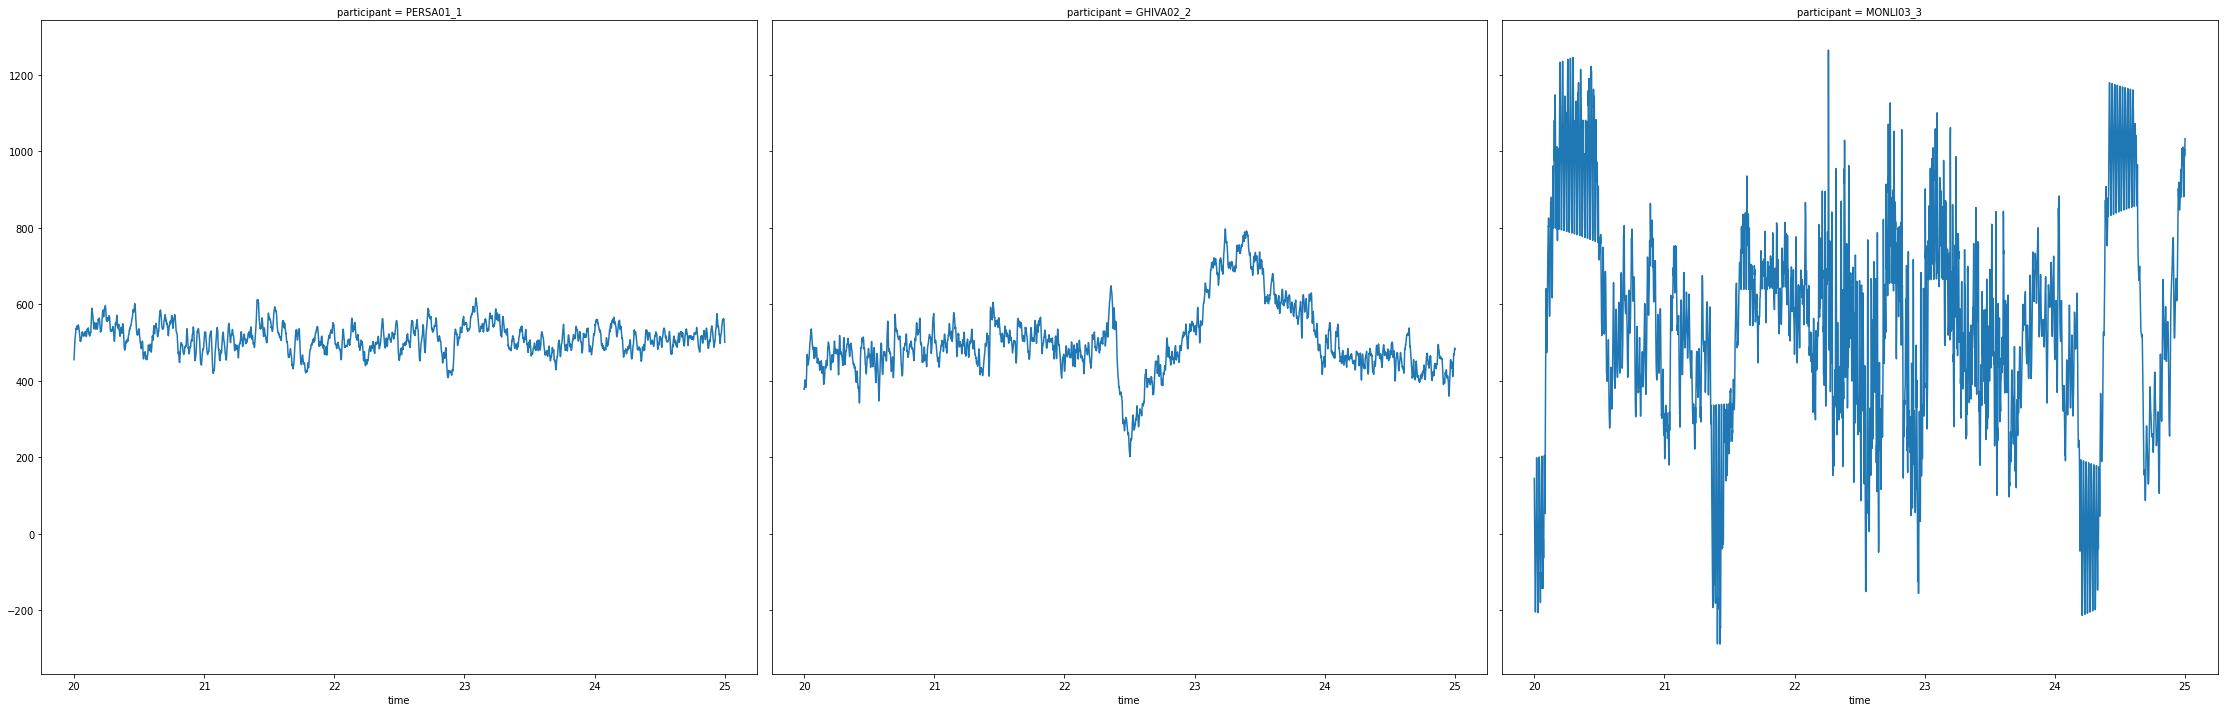

In [185]:
da_both.loc['clean',:,'ECG',20:25].plot.line(x='time', hue='cleaning',col='participant', size = 10)

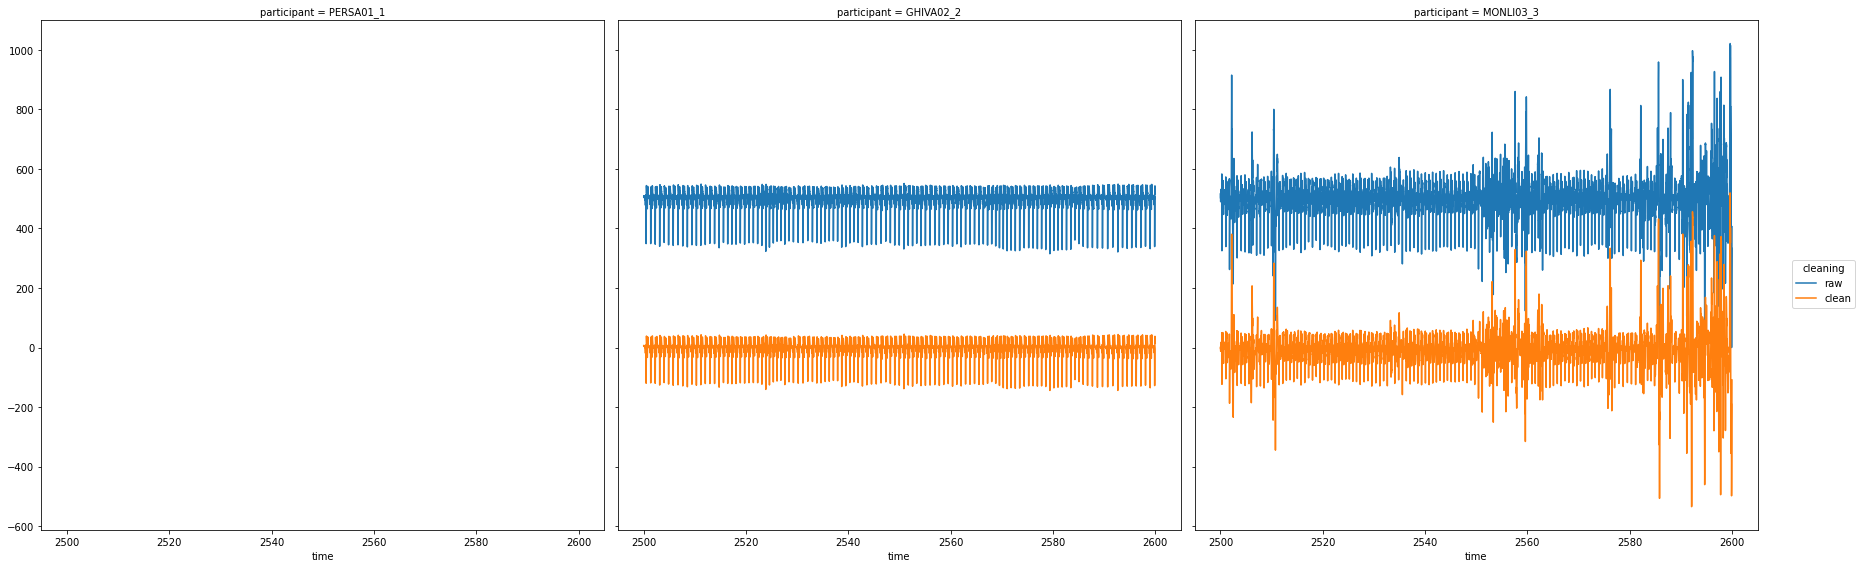

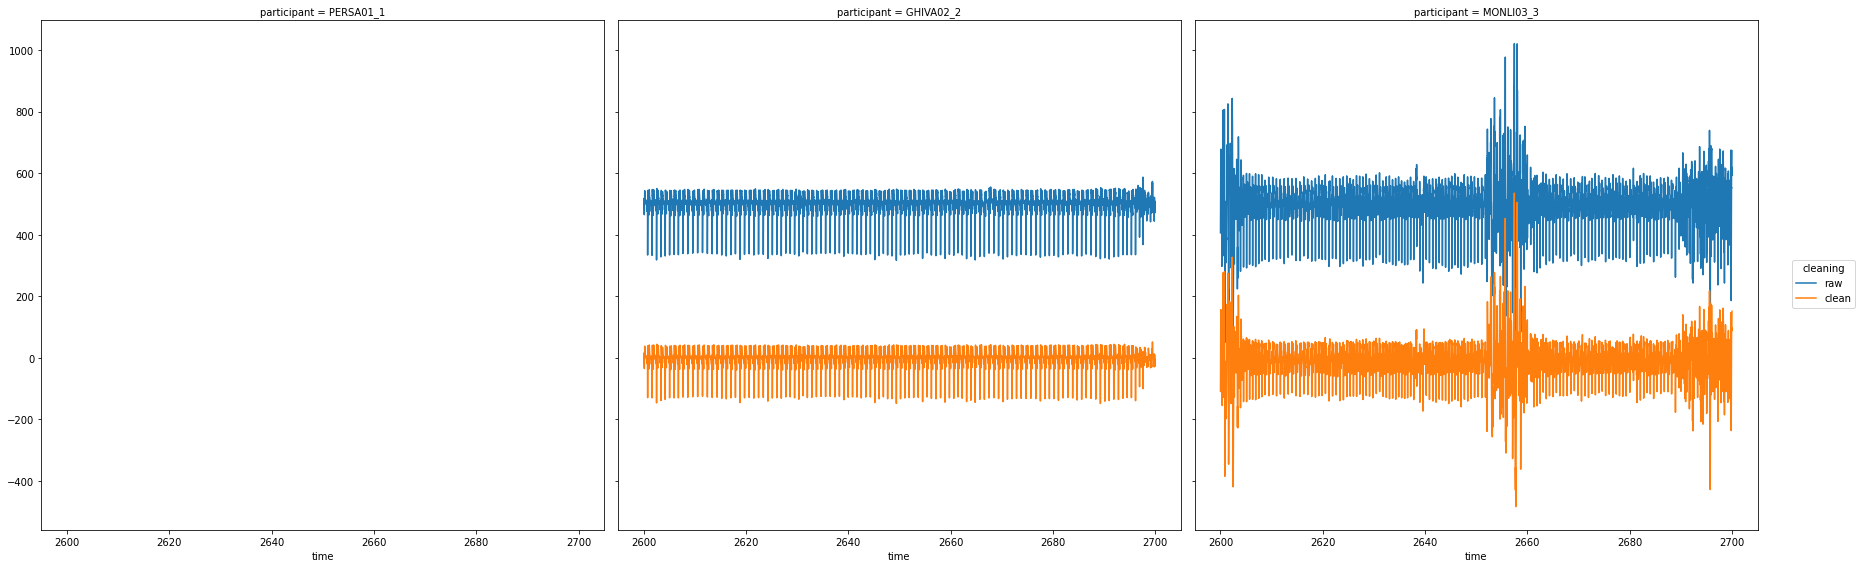

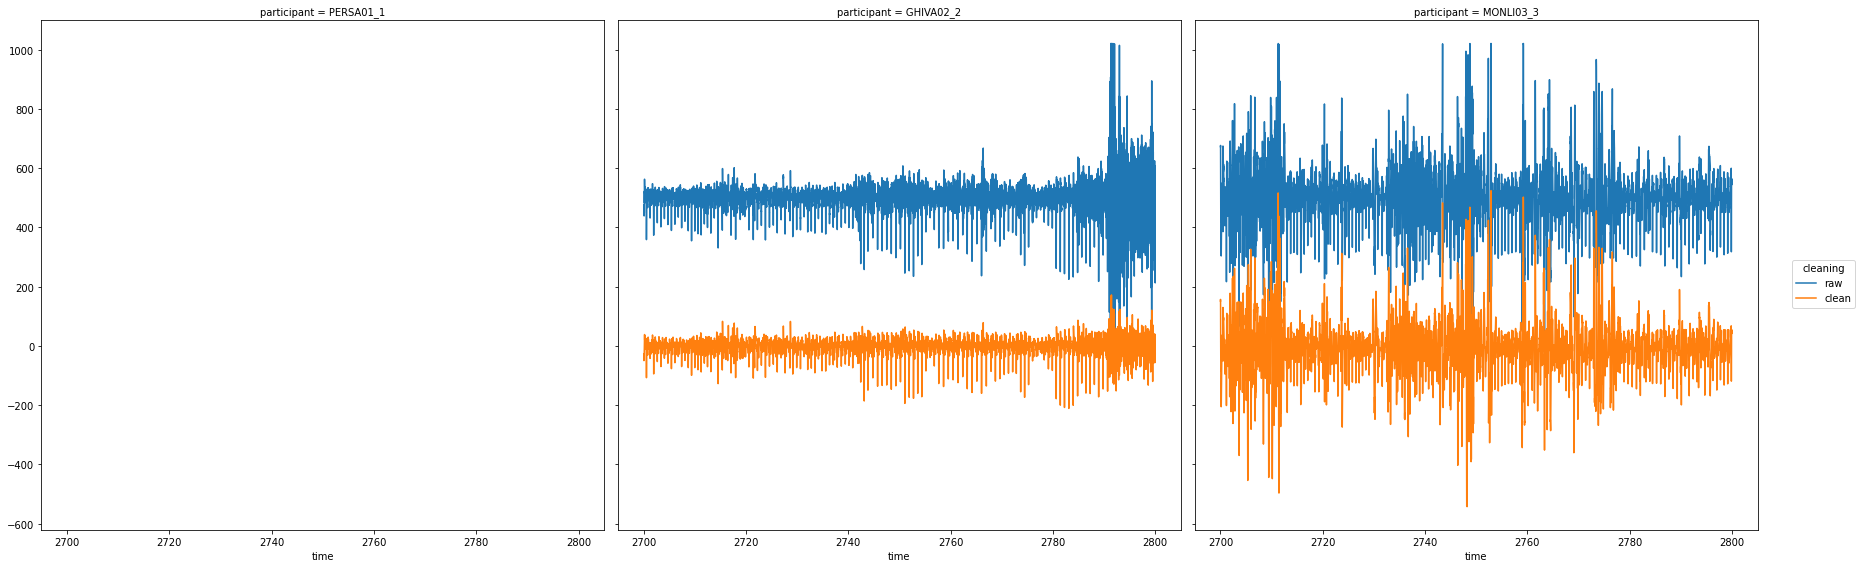

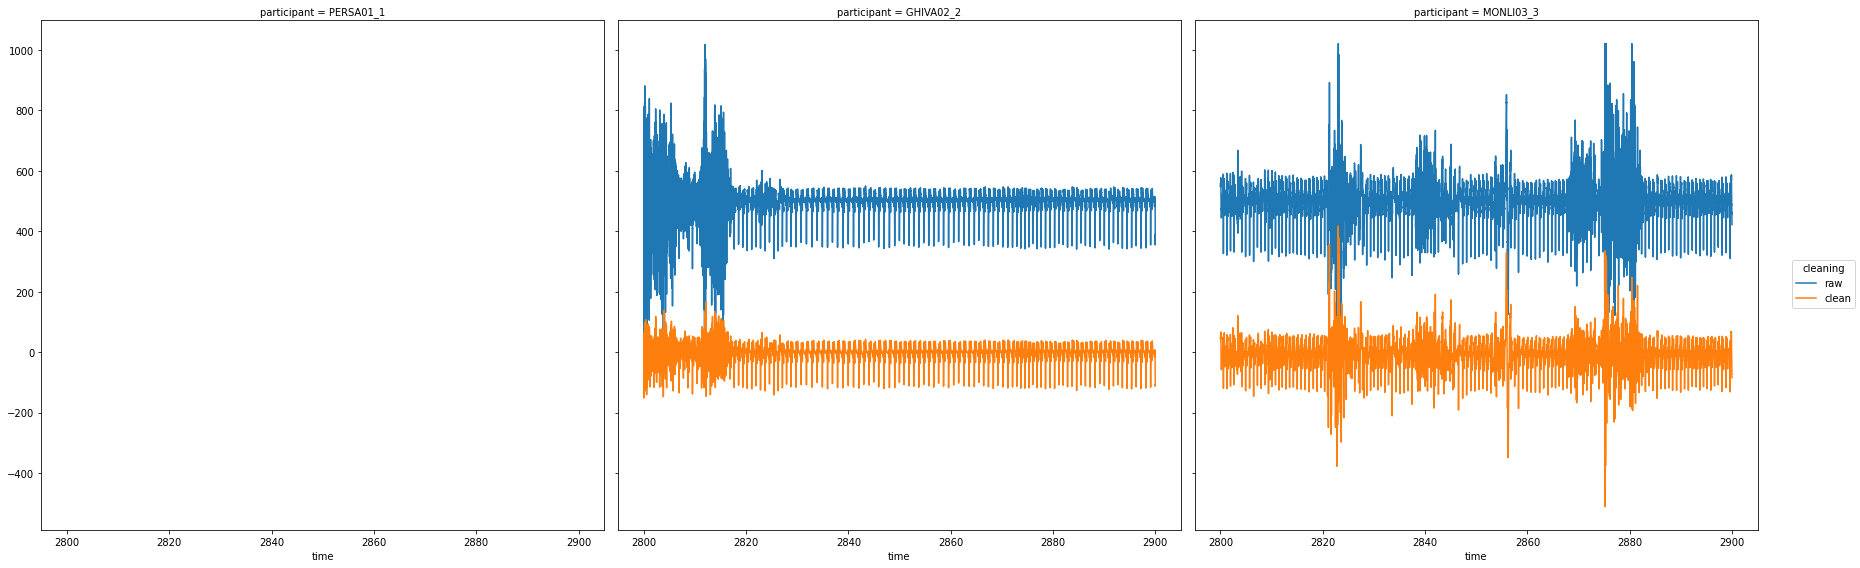

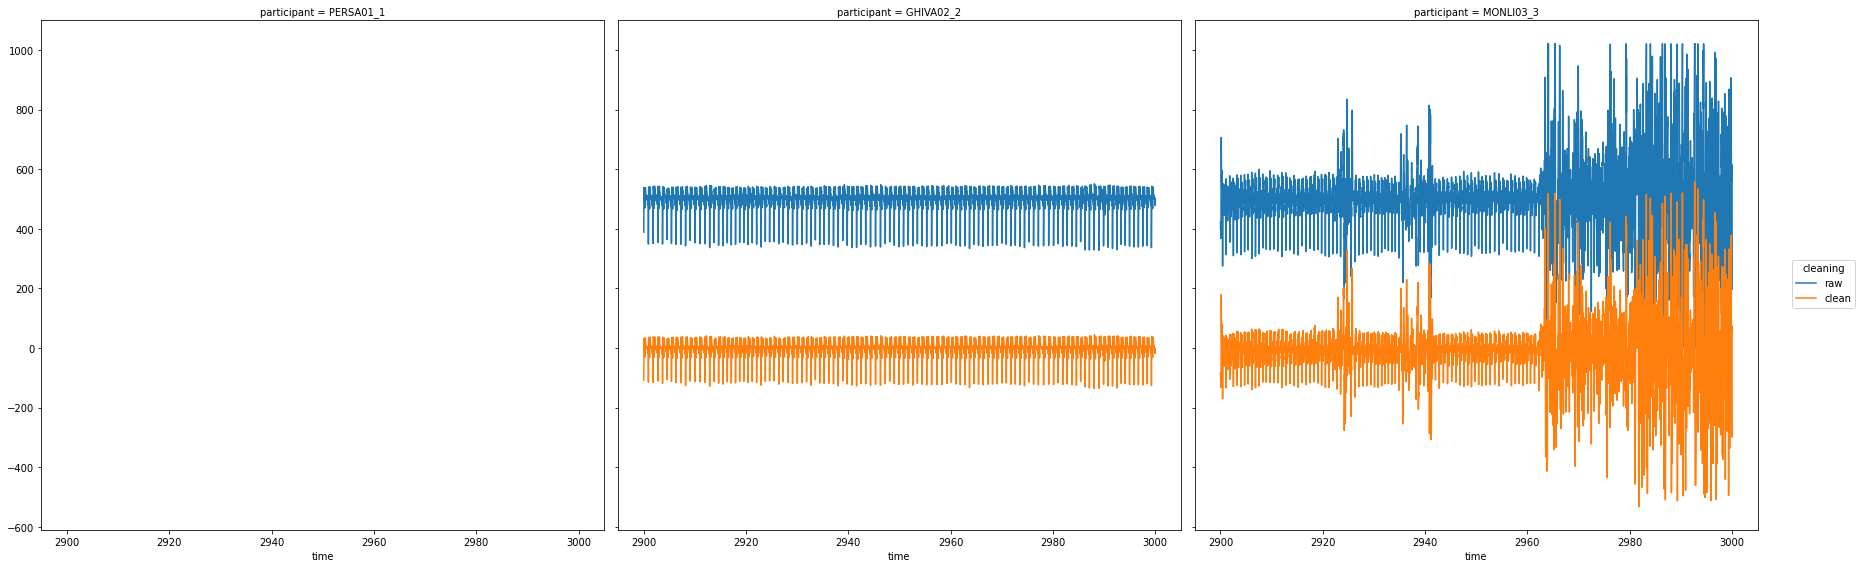

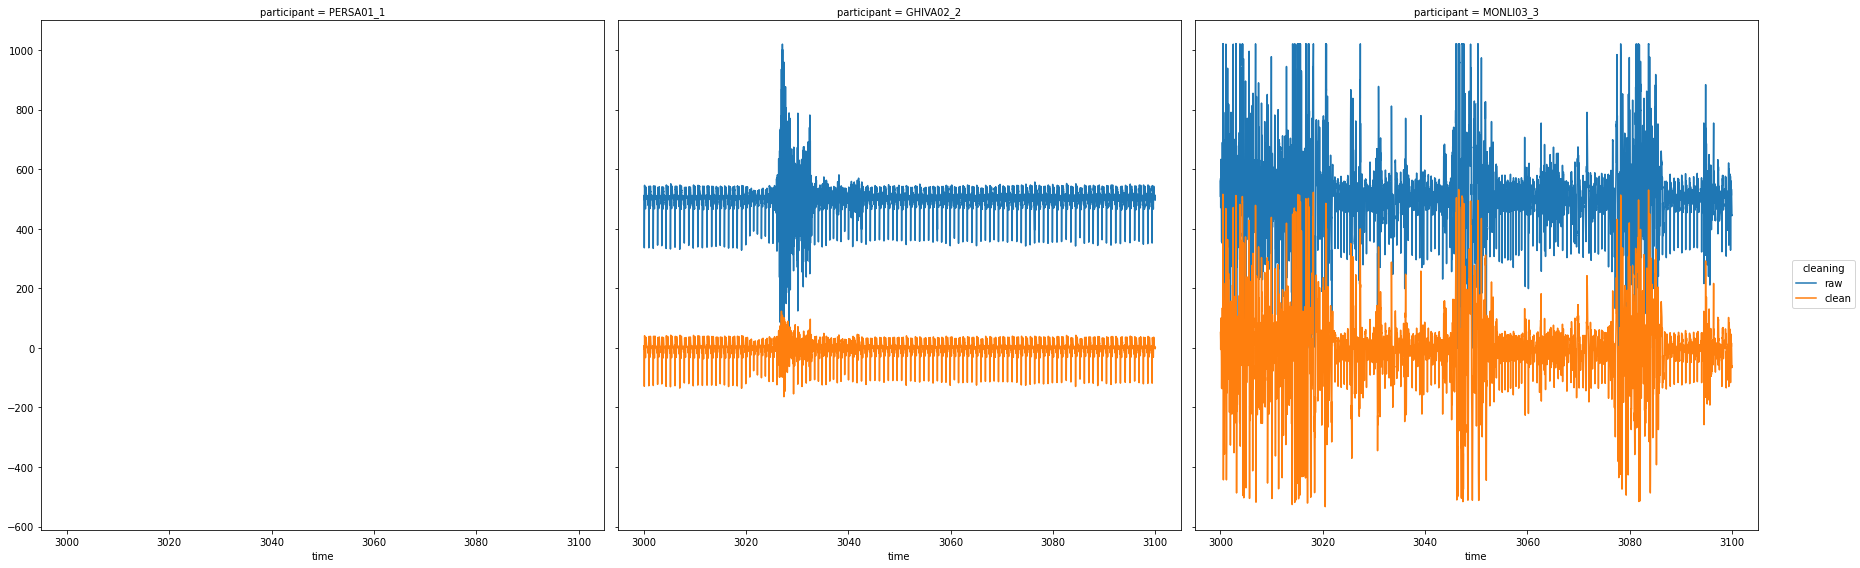

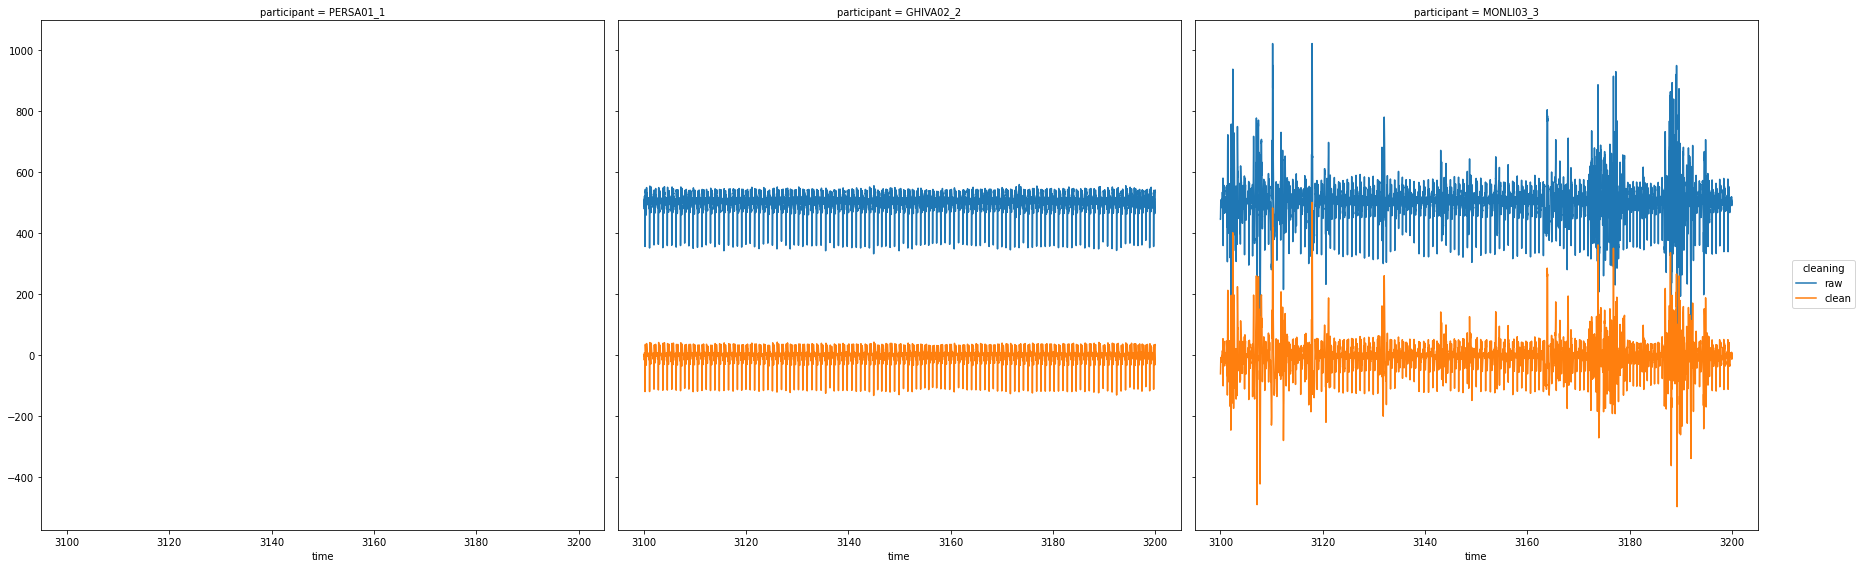

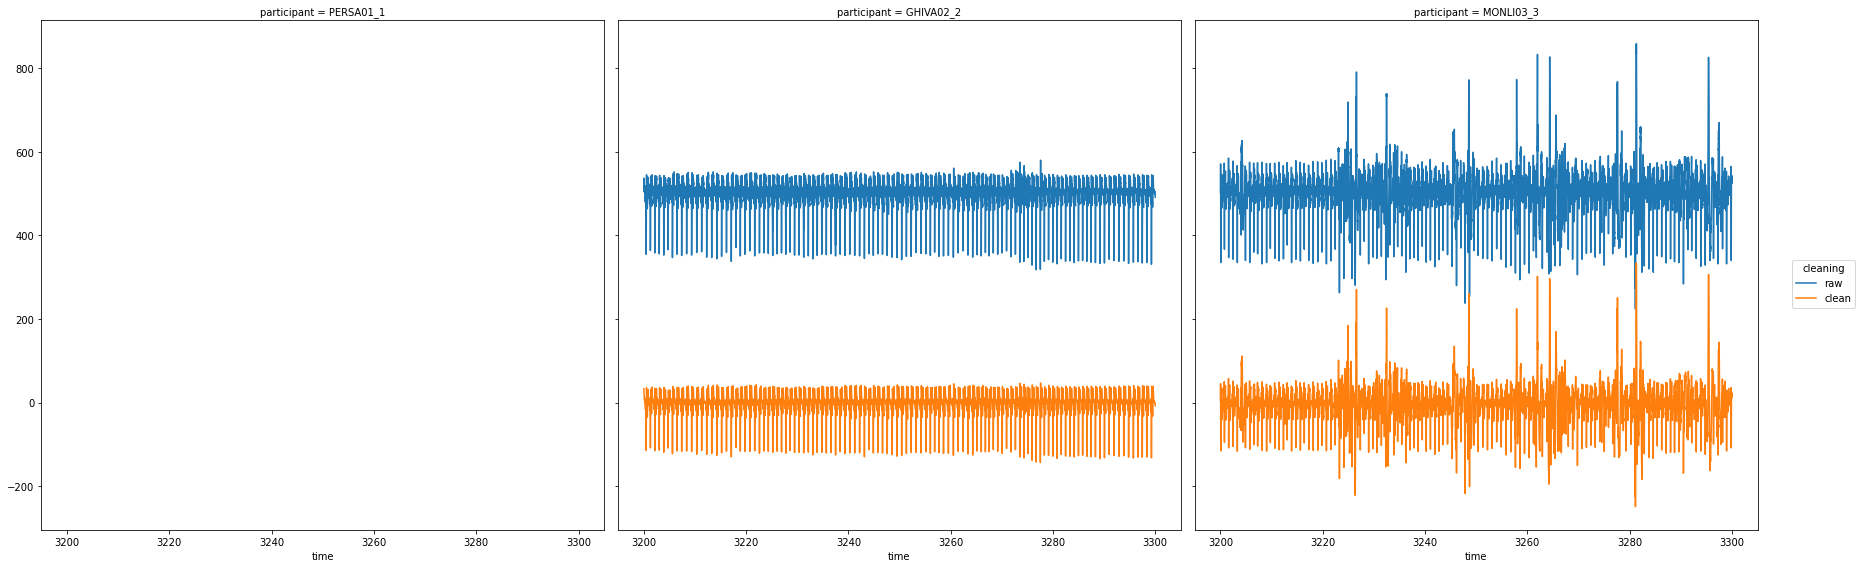

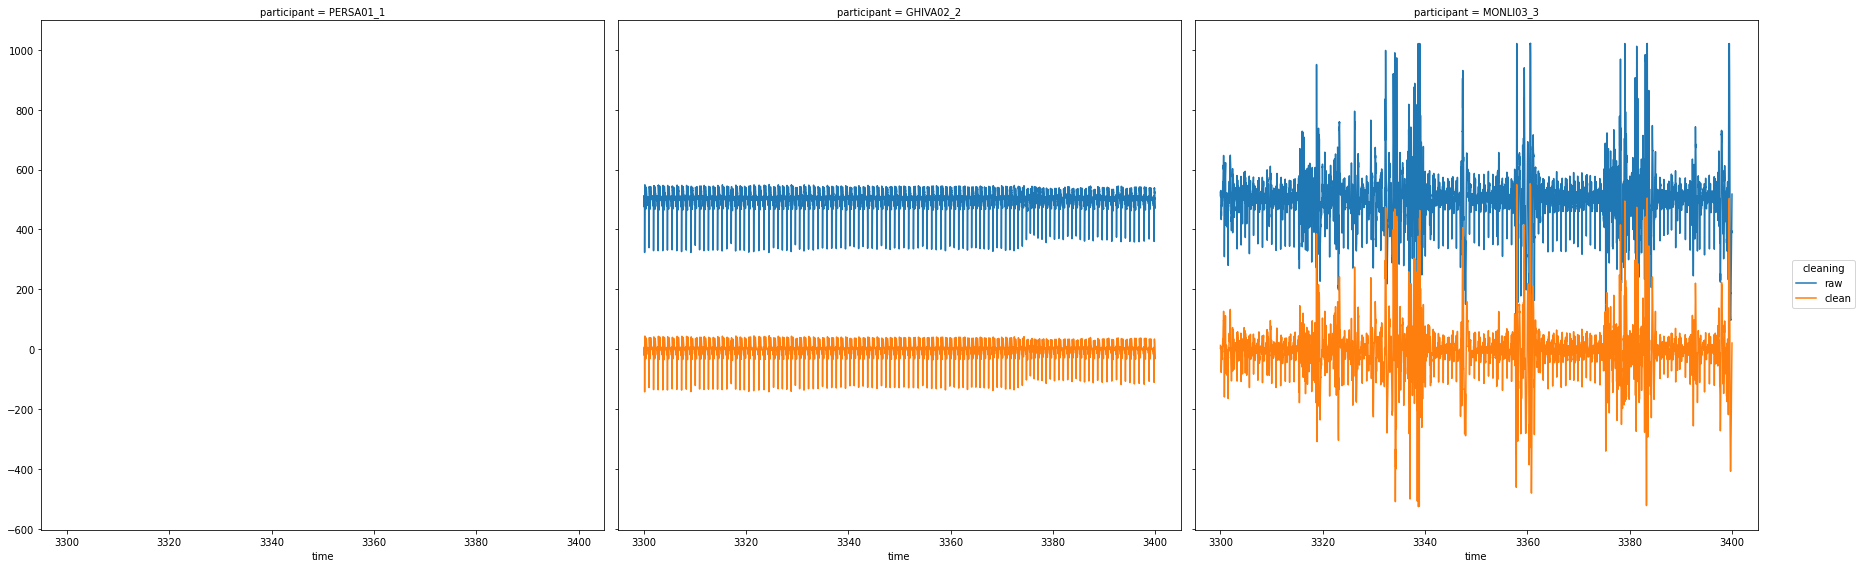

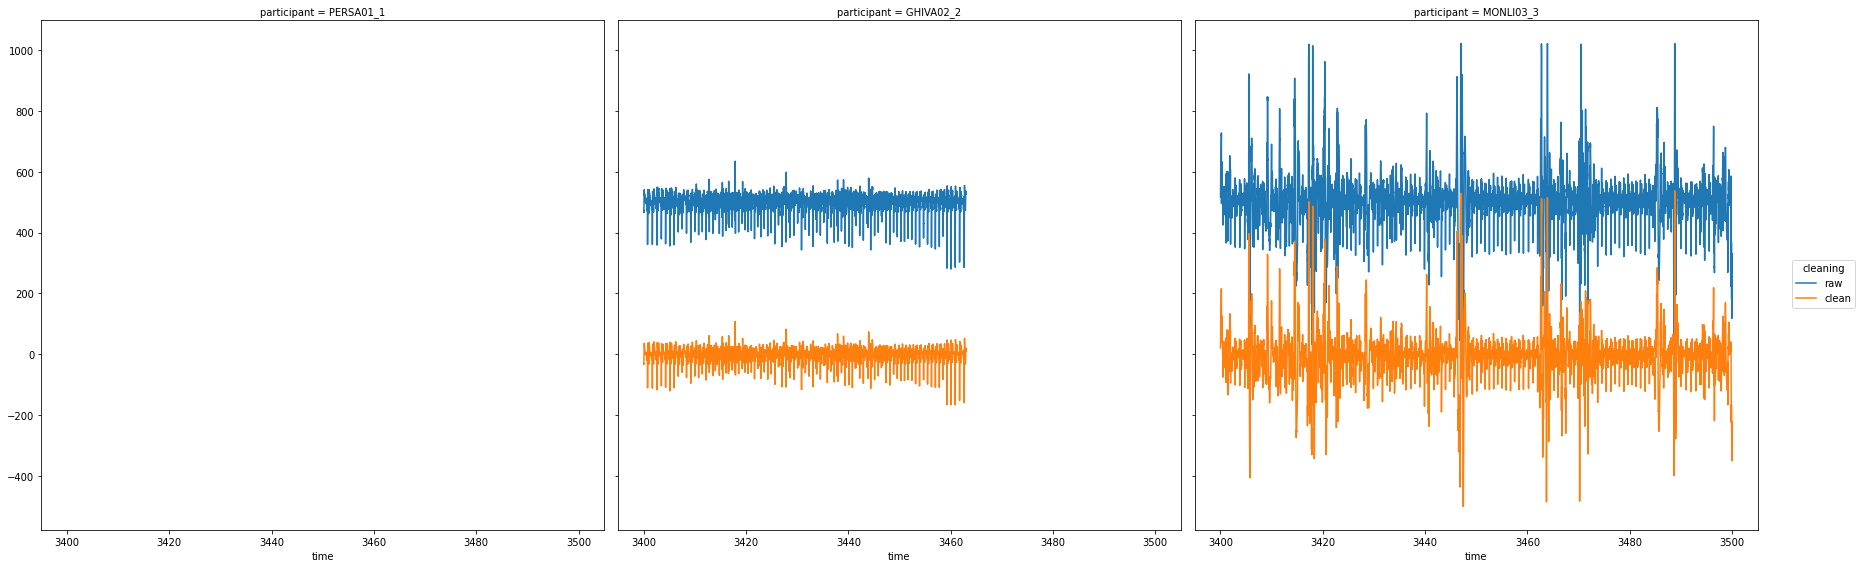

In [188]:
for start in range(2500, 3500 , 100):
    da_both.loc[:,:,'ECG',start:start+100].plot.line(x='time', col = 'participant', hue = 'cleaning', size = 8)

In [153]:
eegs = da_both.loc['clean','GHIVA02_2',['EEGR','EEGL'],:].dropna(dim='time').values

In [154]:
eegs

array([[633.        , 632.05895248, 620.14967473, ..., 454.44336555,
        457.6529597 , 467.        ],
       [377.        , 414.87385131, 457.70504593, ..., 448.12846714,
        453.24364495, 462.        ]])

In [155]:
eegs.shape

(2, 3463000)

In [163]:
info =  mne.create_info(ch_names=['EEGR', 'EEGL'],ch_types=['eeg','eog'], sfreq=1000)
raw = mne.io.RawArray(eegs, info)

Creating RawArray with float64 data, n_channels=2, n_times=3463000
    Range : 0 ... 3462999 =      0.000 ...  3462.999 secs
Ready.


In [189]:
om_detect = mne.preprocessing.find_eog_events(raw, event_id = 999)

Using EOG channel: EEGL
EOG channel index for this subject is: [1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 2817 significant peaks
Number of EOG events detected: 2817


In [194]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, event_id = 999)

Using EOG channel: EEGL
EOG channel index for this subject is: [1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 2817 significant peaks
Number of EOG events detected: 2817
Not setting metadata
Not setting metadata
2817 matching events found
No baseline correction applied
Loading data for 2817 events and 1001 original time points ...
0 bad epochs dropped


In [198]:
# eog_epochs.plot()

In [190]:
om_detect

array([[    865,       0,     999],
       [   2418,       0,     999],
       [   2857,       0,     999],
       ...,
       [3457301,       0,     999],
       [3458511,       0,     999],
       [3459246,       0,     999]])

In [192]:
%matplotlib widget